In [1]:
using Arrhenius
using ForwardDiff
using LinearAlgebra
using DiffEqSensitivity
using DifferentialEquations

using Random
using ProgressBars
using DelimitedFiles
using Plots, Colors, Printf, Profile

┌ Info: Precompiling Arrhenius [d1b5debe-99ef-4a51-88bd-55361cc46b8b]
└ @ Base loading.jl:1278


## 1. Validation of Pyrolysis Simulation 

### 1.1 Load Cantera results

In [2]:
cantera_data = readdlm("pyrolysis.dat");
ct_t = cantera_data[:, 1];
ct_T = cantera_data[:, 2];
ct_Y = cantera_data[:, 3:end];
ct_u = hcat(ct_Y, ct_T)';

### 1.2 Simulate in `Arrhenius.jl`

In [3]:
gas = CreateSolution("../../mechanism/JP10skeletal.yaml");
ns = gas.n_species;
nr = gas.n_reactions;
gas.species_names;

Y0 = zeros(ns);
Y0[species_index(gas, "C10H16")] = 0.05;
Y0[species_index(gas, "N2")] = 0.95;
T0 = 1200.0;
P = one_atm;
u0 = vcat(Y0, T0);

@inbounds function dudt!(du, u, p, t)
    T = u[end]
    Y = @view(u[1:ns])
    
    mean_MW = 1. / dot(Y, 1 ./ gas.MW)
    ρ_mass = P / R / T * mean_MW
    X = Y2X(gas, Y, mean_MW)
    C = Y2C(gas, Y, ρ_mass)
    cp_mole, cp_mass = get_cp(gas, T, X, mean_MW)
    h_mole = get_H(gas, T, Y, X)
    S0 = get_S(gas, T, P, X)
    
    wdot = wdot_func(gas.reaction, T, C, S0, h_mole)
    
    Ydot = wdot / ρ_mass .* gas.MW
    Tdot = -dot(h_mole, wdot) / ρ_mass / cp_mass
    du .= vcat(Ydot, Tdot)
end

# reltol=1e-3
# abstol=1e-6

# reltol=1e-6
# abstol=1e-9

reltol=1e-9
abstol=1e-12

tspan = [0.0, ct_t[end]*1.001];
prob = ODEProblem(dudt!, u0, tspan);
sol = solve(prob, TRBDF2(), reltol=reltol, abstol=abstol, saveat=ct_t);
ar_t = sol.t;
ar_u = Array(sol);

### 1.3 Validation

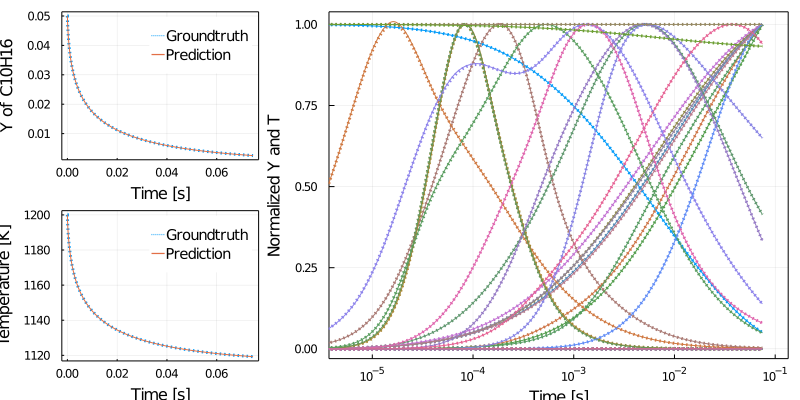

In [4]:
fs = 10;
xlim = [5e-6, 1e-1];

function valid(t, y_true, y_pred, xscale)
    IJulia.clear_output(true)
    
    h1 = plot(legend=true, legendfontsize=fs, foreground_color_legend=nothing)
    plot!(t, y_true[species_index(gas, "C10H16"),:], line=(3,:dot), label="Groundtruth")
    plot!(t, y_pred[species_index(gas, "C10H16"),:], line=(1,:solid), label="Prediction")
    ylabel!(h1, "Y of C10H16")
    xlabel!(h1, "Time [s]")
    
    h2 = plot(legend=true, legendfontsize=fs, foreground_color_legend=nothing)
    plot!(t, y_true[end,:], line=(3,:dot), label="Groundtruth")
    plot!(t, y_pred[end,:], line=(1,:solid), label="Prediction")
    ylabel!(h2, "Temperature [K]")
    xlabel!(h2, "Time [s]")
    
    scale = max.(maximum(abs.(y_true), dims=2), 1e-16)
    h3 = plot(palette=palette(:default, length(scale)), xscale=xscale,
            xlim=xlim, legend=false)
    plot!(t[2:end], (y_true[:,2:end]./scale)', line=(3, :dot))
    plot!(t[2:end], (y_pred[:,2:end]./scale)', line=(1, :solid))
    ylabel!(h3, "Normalized Y and T")
    xlabel!(h3, "Time [s]")
    
    h = plot(h1, h2, h3, layout=@layout[grid(2,1) a{0.7w}], size=(800,400), framestyle=:box)
    display(h)
    sleep(1e-9)
end
valid(ct_t, ct_u, ar_u, :log10)

## 2. Optimization

In [5]:
using Flux
using Flux: crossentropy
using Flux.Losses: mae
using Flux.Optimise: update!
using LatinHypercubeSampling
using Statistics
using DiffEqFlux

In [6]:
# settings
solver = TRBDF2();

datasize = 100;
tsteps = 10 .^ range(log10(1e-8), log10(1e-1), length=datasize);
tspan = [0.0, tsteps[end]*1.001];

rng = MersenneTwister(0x7777777);
p_true = zeros(nr);
p_pred = 0.5*(2*rand(rng, nr).-1);
p_init = deepcopy(p_pred);

grad_max = 10 ^ (1);

### 2.1 Test for gradient computation

In [7]:
# ODE function
@inbounds function dudtp!(du, u, p, t)
    T = u[end]
    Y = @view(u[1:ns])
    
    mean_MW = 1. / dot(Y, 1 ./ gas.MW)
    ρ_mass = P / R / T * mean_MW
    X = Y2X(gas, Y, mean_MW)
    C = Y2C(gas, Y, ρ_mass)
    cp_mole, cp_mass = get_cp(gas, T, X, mean_MW)
    h_mole = get_H(gas, T, Y, X)
    S0 = get_S(gas, T, P, X)
    
    qdot = wdot_func(gas.reaction, T, C, S0, h_mole, get_qdot = true)
    wdot = gas.reaction.vk * (qdot .* exp.(p))
    
    Ydot = wdot / ρ_mass .* gas.MW
    Tdot = -dot(h_mole, wdot) / ρ_mass / cp_mass
    du .= vcat(Ydot, Tdot)
end

dudtp! (generic function with 1 method)

In [8]:
prob = ODEProblem(dudtp!, u0, tspan);

function fsol(p)
    sol = solve(prob, u0=u0, solver, p=p, tspan=tspan, saveat=tsteps,
                reltol=1e-3, abstol=1e-6, sensealg=sensealg)
    return sol[end, end]
end

# sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP(false))
# sensealg = BacksolveAdjoint(autojacvec=ReverseDiffVJP(false))
sensealg = ForwardDiffSensitivity()
# sensealg = ForwardSensitivity(autojacvec=true)

# solver = Rosenbrock23()
solver = TRBDF2()

println("timing ode solver ...")
@time fsol(p_true)
@time fsol(p_true)
@time ForwardDiff.gradient(fsol, p_true)
@time ForwardDiff.gradient(fsol, p_true)'

timing ode solver ...
 12.792070 seconds (32.35 M allocations: 1.782 GiB, 6.39% gc time)
  0.046642 seconds (23.04 k allocations: 14.464 MiB, 62.04% gc time)
 38.768797 seconds (96.34 M allocations: 7.830 GiB, 3.70% gc time)
  2.201466 seconds (841.75 k allocations: 3.848 GiB, 6.07% gc time)


1×232 Adjoint{Float64,Array{Float64,1}}:
 -4.57061  0.785758  0.0232836  …  -3.0068e-30  4.14211e-7  -0.293975

### 2.2 Generate Datasets

In [9]:
n_exp_train = 20;
n_exp_valid = 5;
n_exp = n_exp_train + n_exp_valid;

noise = 0;
abstol = 1e-9;
reltol = 1e-12;

ns = gas.n_species;

rng = MersenneTwister(0x7777777);

u0_list = zeros(Float64, (n_exp, ns+1));
randvals = randomLHC(rng, n_exp, 2) ./ n_exp;
for i in range(1, length=n_exp)
    Y0 = zeros(ns);
    T0 = 1000 + 200*randvals[i,1]; # 1000-1200K
    val = 0.05 + 0.25*randvals[i,2]; # Y[JP10] = 0.05-0.3
    Y0[species_index(gas, "C10H16")] = val;
    Y0[species_index(gas, "N2")] = 1 - val;
    u0 = vcat(Y0, T0);
    u0_list[i,:] = u0;
end
P = one_atm;

datasize = 100;
tsteps = 10 .^ range(log10(1e-8), log10(1e-1), length=datasize);
tspan = [0.0, tsteps[end]*1.001];

y_true_list = zeros(Float64, (n_exp, ns+1, datasize));
y_init_list = zeros(Float64, (n_exp, ns+1, datasize));
yscale_list = [];

max_min(y) = maximum(y, dims=2) .- minimum(y, dims=2);
for i = 1:n_exp
    u0 = u0_list[i, :]
    _prob = ODEProblem(dudtp!, u0, tspan, p_true)
    y_true = Array(solve(_prob, solver, saveat=tsteps, abstol=abstol, reltol=reltol))
    y_true += noise * randn(size(y_true)) .* y_true
    y_true_list[i, :, :] = y_true
    push!(yscale_list, max_min(y_true))
end

for i = 1:n_exp
    u0 = u0_list[i, :]
    _prob = ODEProblem(dudtp!, u0, tspan, p_init)
    y_init = Array(solve(_prob, solver, saveat=tsteps, abstol=abstol, reltol=reltol))
    y_init_list[i, :, :] = y_init
end

In [10]:
yscale_raw = maximum(abs.(hcat(yscale_list...)), dims=2);
yscale = max.(yscale_raw, 1e-16);
# show(stdout, "text/plain", yscale');

### 2.3 Compare wrong initial `y_init`

#### Case 1: First training set

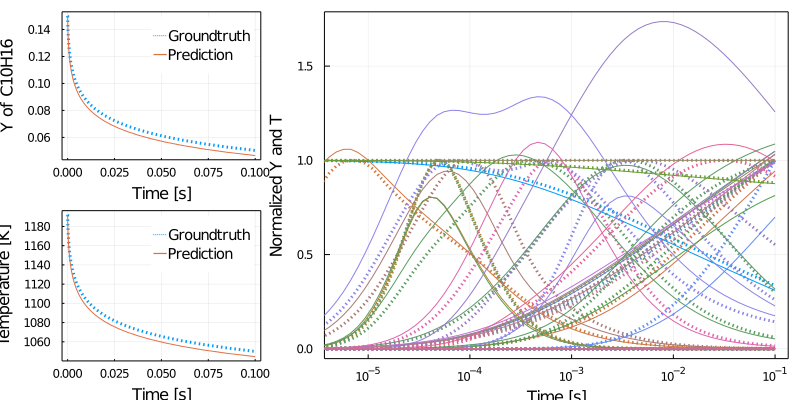

In [11]:
y_true = y_true_list[1,:,:]
y_init = y_init_list[1,:,:]
valid(tsteps, y_true, y_init, :log10)

#### Case 2: First validation set

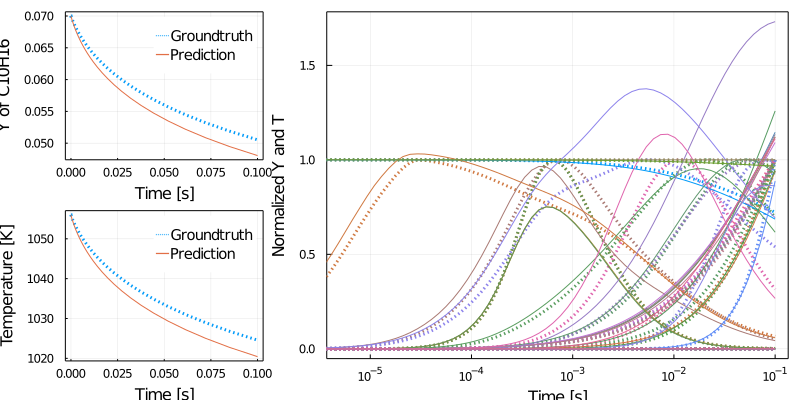

In [12]:
y_true = y_true_list[n_exp_train+1,:,:]
y_init = y_init_list[n_exp_train+1,:,:]
valid(tsteps, y_true, y_init, :log10)

In [13]:
# Regularization of parameters
vecnorm(x) = sum(abs2,x)./length(x)
vecnorm(p_init-p_true)

0.0800726189657617

In [14]:
sensealg = ForwardDiffSensitivity()
function predict_ode(u0, p; sample = datasize)
    _prob = remake(prob, u0=u0, p=p, tspan=[0, tsteps[sample]])
    sol = solve(_prob, solver, saveat=tsteps[1:sample], sensalg=sensealg,
                reltol=reltol, abstol=abstol, verbose=false)
    pred = Array(sol)
    if sol.retcode == :Success
        nothing
    else
        println("ode solver failed")
    end
    return pred
end

function loss_ode(p, i_exp; abstol=1e-12, sample = datasize)
    y_pred = predict_ode(u0_list[i_exp,:], p; sample)
    y_true = y_true_list[i_exp,:,1:sample]
    yscale = max.(yscale_raw, abstol);
    loss = mae(y_true./yscale, y_pred./yscale) + vecnorm(p-p_init)/100
    return loss
end

loss_ode(p_init, 1)

0.01440423278218457

In [15]:
loss_ode(p_init, n_exp_train+1; abstol=1e-9)

0.0017531261286931428

### 2.4 Training by Datasets

In [16]:
losses_y_train = Vector{Float64}();
losses_y_valid = Vector{Float64}();
losses_p = Vector{Float64}();
history_p_pred = Vector{Array{Float64}}();
push!(history_p_pred, p_init);

In [17]:
function train(opt; n_epoch=10, batchsize=50, reltol=1e-6, abstol=1e-9)
    epochs = ProgressBar(1:n_epoch);
    loss_epoch = zeros(Float64, n_exp);
    grad_norm = zeros(Float64, n_exp_train);
    for epoch in epochs
        # update parameters
        global p_pred
        for i_exp in randperm(n_exp_train)
            sample = rand(batchsize:datasize)
            grad = ForwardDiff.gradient(
                        x -> loss_ode(x, i_exp; abstol=abstol, sample),
                        p_pred)
            grad_norm[i_exp] = norm(grad, 2)
            if grad_norm[i_exp] > grad_max
                grad = grad ./ grad_norm[i_exp] .* grad_max
            end
            update!(opt, p_pred, grad)
        end

        # save losses
        for i_exp in 1:n_exp
            loss_epoch[i_exp] = loss_ode(p_pred, i_exp; abstol=abstol)
        end
        loss_y_train = mean(loss_epoch[1:n_exp_train]);
        loss_y_valid = mean(loss_epoch[n_exp_train+1:end]);
        loss_p = mae(p_pred, p_true)
        push!(history_p_pred, deepcopy(p_pred))
        push!(losses_y_train, loss_y_train)
        push!(losses_p, loss_p)
        
        # show results
        if epoch%2==0
            u0 = u0_list[n_exp_train+1,:]
            _prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
            y_pred = Array(solve(_prob, solver, saveat=tsteps, sensalg=sensealg,
                        reltol=reltol, abstol=abstol, verbose=false))
            valid(tsteps, y_true_list[n_exp_train+1,:,:], y_pred, :log10)
        end
        set_description(epochs, string(@sprintf("Loss ytrain %.3e yvalid %.3e p %.3e gnorm %.3e",
                    loss_y_train, loss_y_valid, loss_p, mean(grad_norm))))
    end
end

train (generic function with 1 method)

In [18]:
# opt = ADAMW(0.05, (0.9, 0.999), 1.f-6);
# train(opt; n_epoch=10, batchsize=48, reltol=1e-3, abstol=1e-6)

In [ ]:
opt = ADAMW(0.05, (0.9, 0.999), 1.f-6);
train(opt; n_epoch=50, batchsize=100, reltol=1e-6, abstol=1e-9)

0.0%┣                                           ┫ 0/50 [00:00<00:-3, -20.0 it/s]


In [ ]:
opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt; n_epoch=50, batchsize=100, reltol=1e-9, abstol=1e-12)

In [ ]:
h1 = plot(line=(3,:dot), yscale=:log10)
plot!(losses_y_train, lc=1, label="y loss train")
plot!(losses_y_valid, lc=2, label="y loss valid")

h2 = plot(line=(3,:dot))
plot!(losses_p, lc=1, label="p loss")

plot(h1, h2, legend=true, size=(800,200), framestyle=:box)

In [ ]:
function valid_p(p_init, p_pred)
    plot(size=(800,200))
    plot!(p_init, line=(3,:dot), label="p_init", linecolor=1)
    plot!(p_pred, line=(3,:dot), label="p_pred", linecolor=2)
end

valid_p(p_init, p_pred)

In [ ]:
reltol = 1e-9;
abstol = 1e-12;
i_exp = 1
u0 = u0_list[i_exp,:]
y_true = y_true_list[i_exp,:,:]
_prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
y_pred = solve(_prob, solver, saveat=tsteps, sensalg=sensealg,
            reltol=reltol, abstol=abstol, verbose=false)
valid(tsteps, y_true, y_pred, :log10)

In [ ]:
valid(tsteps, y_true, y_pred, :linear)

In [ ]:
for i=1:25
    @show loss_ode(p_pred, i)
end
# vecnorm(p_init-p_pred)

In [ ]:
i_exp = n_exp
u0 = u0_list[i_exp,:]
y_true = y_true_list[i_exp,:,:]
_prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
y_pred = solve(_prob, solver, saveat=tsteps, sensalg=sensealg,
            reltol=reltol, abstol=abstol, verbose=false)
valid(tsteps, y_true, y_pred, :log10)

In [ ]:
p_indexs = Vector{Int64}();
p_change = Vector{Float64}();
plot(p_pred - p_init)
for i in 1:nr
    if abs(p_pred[i] - p_init[i]) > 1e-2
        push!(p_indexs, i)
    end
end
plot()
scatter!(p_indexs, p_init[p_indexs], label="p_init")
scatter!(p_indexs, p_pred[p_indexs], label="p_pred")